In [1]:
#==============================================================================
#
# IMPORT LIBRARIES
# 
#==============================================================================
import time
import pandas as pd
#pd.options.display.max_columns = None # Shows all columns
import string as str
import numpy as np
import matplotlib.pyplot as plt
import dill
import dask
import dask.dataframe as dd

#import csv
#from googletrans import Translator
#import copy
#import numpy as np

In [2]:
#==============================================================================
# 
# DUMP/LOAD SESSIONS
# 
#==============================================================================
# ---- FULL SESSIONS ----
# Dump
#dill.dump_session('./working.db')

# Load
#dill.load_session('working.db')

# ---- OBJECTS ----
# Dump
#dill.dump(df_raw, open("df_raw.pkl", "wb"))

# Load
#dill_file = open("df_raw.pkl", "rb")
#df_raw = dill.load(dill_file)
#dill_file.close()

In [3]:
#==============================================================================
# 
# READ/EXTRACT RAW DATA
# 
#==============================================================================

file_train = 'data/dataset/yes_complete/train.txt'
print(pd.read_table(file_train, nrows=5, header=None))

                                                   0
0  17430147 17277121 17767569 17352501 17567841 1...
1  138 2833 297 502 700 5041 3235 72 1004 2 1 116...
2  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3  78 79 80 3 62 81 14 82 48 83 84 17 85 86 87 88...
4  211 212 213 59 25 214 215 57 93 216 70 3 81 62...


In [4]:
with open(file_train) as f:
    train_raw = f.readlines()

In [5]:
playlists_train_raw = train_raw[2:]

In [6]:
# How many unique playlists?
print('There are ', len(playlists_train_raw), ' playlists.', sep='')

There are 11137 playlists.


In [7]:
# Split playlist IDs and convert to integers
playlists_train_list = []
for i in range(0, len(playlists_train_raw)):
    playlists_train_list.append(list(map(int, playlists_train_raw[i].split())))

In [8]:
# Flatmap the playlists list
df_playlists_train = []
for i in range(0, len(playlists_train_list)):
    for j in range(0, len(playlists_train_list[i])):
        df_playlists_train.append([i, playlists_train_list[i][j]])

In [9]:
df_playlists_train = pd.DataFrame(df_playlists_train, columns=['playlist', 'song_id'])

In [10]:
len(df_playlists_train)

1887938

In [11]:
# Create index primary key
df_playlists_train.insert(loc=0, column='index', value=df_playlists_train.index)

In [12]:
# ---- Merge songs on song_id ----
df_song_hash = pd.read_table('data/dataset/yes_complete/song_hash.txt', header=None, names=['song_id','song','band'])

In [13]:
df_playlists_train = df_playlists_train.merge(df_song_hash, on='song_id')
df_playlists_train.sort_values('index', inplace=True)
df_playlists_train.reset_index(drop=True, inplace=True)

In [14]:
df_playlists_train.head()

,index,playlist,song_id,song,band
0,0,0,0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,1,0,1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,2,0,2,Get Back Up (w\/ Chris Brown),T.I.
3,3,0,3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,4,0,4,Whip My Hair,Willow


In [15]:
#==============================================================================
#
# EDA
# 
#==============================================================================

In [16]:
#song_count = pd.DataFrame(df_playlists_train.groupby(['song', 'band'])['playlist'].count().sort_values(ascending=False))
song_count = df_playlists_train.groupby(['song_id','song','band']).count().reset_index().drop(columns='index')
song_count.columns = ['song_id','song','band','count']
song_count = song_count.sort_values('count', ascending=False)
song_count.reset_index(inplace=True)
song_count = song_count[['song_id','song','band','count']]

Text(0.5,1,'')

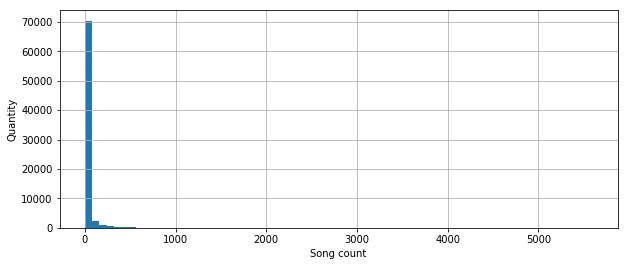

In [17]:
plt.figure(figsize=(10,4))
song_count['count'].hist(bins=70)
plt.xlabel('Song count')
plt.ylabel('Quantity')
plt.title('')

(0, 25)

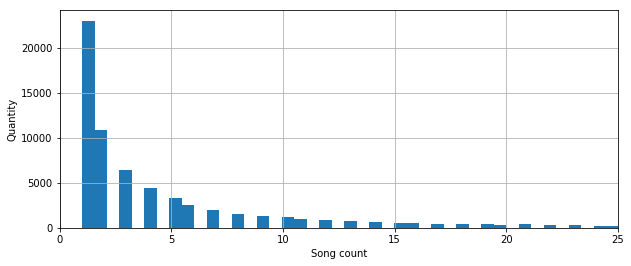

In [18]:
plt.figure(figsize=(10,4))
song_count['count'].hist(bins=10000)
plt.xlabel('Song count')
plt.ylabel('Quantity')
plt.title('')
plt.xlim(0,25)

(5, 20)

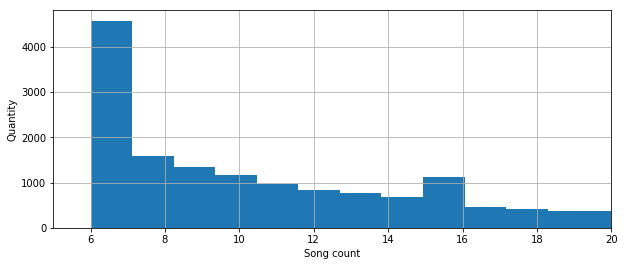

In [19]:
plt.figure(figsize=(10,4))
song_count[song_count['count'] > 5]['count'].hist(bins=5000)
plt.xlabel('Song count')
plt.ylabel('Quantity')
plt.title('')
plt.xlim(5,20)

In [20]:
band_count = pd.DataFrame(df_playlists_train.groupby('band')['playlist'].count().sort_values(ascending=False))
band_count.reset_index(inplace=True)
band_count.columns = ['band','count']

In [21]:
band_count.head()

,band,count
0,Rihanna,12550
1,Nicki Minaj,10228
2,Kenny Chesney,10181
3,Brad Paisley,9128
4,Chris Brown,9096


Text(0.5,1,'')

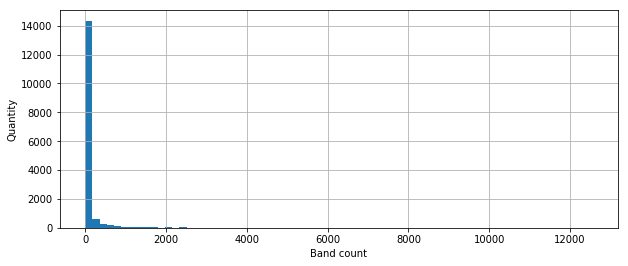

In [22]:
plt.figure(figsize=(10,4))
band_count['count'].hist(bins=70)
plt.xlabel('Band count')
plt.ylabel('Quantity')
plt.title('')

(0, 100)

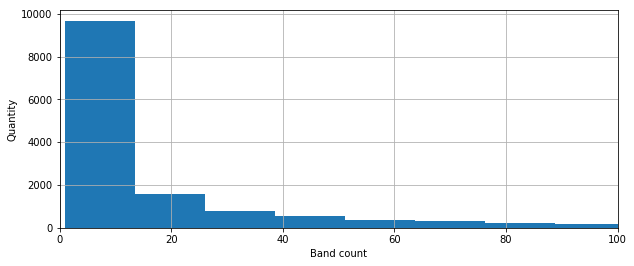

In [23]:
plt.figure(figsize=(10,4))
band_count['count'].hist(bins=1000)
plt.xlabel('Band count')
plt.ylabel('Quantity')
plt.title('')
plt.xlim(0,100)

In [24]:
#==============================================================================
#
# CLEAN DATA
# 
#==============================================================================

In [25]:
len(df_playlists_train)

1887938

In [26]:
df_playlists_train = pd.merge(df_playlists_train, song_count)
df_playlists_train.sort_values(by='index', inplace=True)
df_playlists_train.reset_index(drop=True, inplace=True)

In [27]:
# ---- PARE DATA ----
# Remove songs that show up less than 6 times
df_playlists_train = df_playlists_train[df_playlists_train['count']>=6]

In [28]:
df_playlists_train.head()

,index,playlist,song_id,song,band,count
0,0,0,0,Gucci Time (w\/ Swizz Beatz),Gucci Mane,138
1,1,0,1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross,2833
2,2,0,2,Get Back Up (w\/ Chris Brown),T.I.,297
3,3,0,3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher,502
4,4,0,4,Whip My Hair,Willow,700


In [29]:
df_playlists_train.sort_values('count').head()

,index,playlist,song_id,song,band,count
824260,824293,4937,20463,North Portland,Robert Glasper,6
864263,864297,5233,8757,You Are Holy,Lisa McClendon,6
1066158,1066214,6672,50944,Joshua,Mulgrew Miller,6
1066157,1066213,6672,38507,Pure Imagination,Bill Mays Trio,6
673854,673873,3956,50183,Scar Tissue,Red Hot Chili Peppers,6


In [30]:
df_playlists_train.sort_values('count').tail()

,index,playlist,song_id,song,band,count
684524,684543,4007,20065,Moment 4 Life (w\/ Drake),Nicki Minaj,5593
1439902,1439985,9007,20065,Moment 4 Life (w\/ Drake),Nicki Minaj,5593
1439895,1439978,9007,20065,Moment 4 Life (w\/ Drake),Nicki Minaj,5593
1823298,1823385,10781,20065,Moment 4 Life (w\/ Drake),Nicki Minaj,5593
638751,638770,3738,20065,Moment 4 Life (w\/ Drake),Nicki Minaj,5593


In [31]:
# ---- REMOVE NULLS ----

In [32]:
df_playlists_train.isnull().sum().sum()

0

In [33]:
df_playlists_train.isna().sum().sum()

0

In [34]:
# ---- REMOVE "", " ", "-" ----
df_playlists_train[df_playlists_train['song'] == '-'].head()

,index,playlist,song_id,song,band,count
66438,66442,359,13382,-,-,25
66623,66627,360,13382,-,-,25
66837,66841,360,13382,-,-,25
67171,67175,361,13382,-,-,25
67277,67281,362,13382,-,-,25


In [35]:
df_playlists_train.drop(df_playlists_train[df_playlists_train['song']=='-'].index, inplace=True)

In [36]:
df_playlists_train[df_playlists_train['song'] == '-']

,index,playlist,song_id,song,band,count


In [37]:
df_playlists_train[df_playlists_train['band'] == '-'].head()

,index,playlist,song_id,song,band,count
424384,424397,2383,37365,MG_DELETED,-,6
532387,532401,3077,43786,Take Me In Your Arms (Rock Me For A Little While),-,7
533274,533290,3083,43786,Take Me In Your Arms (Rock Me For A Little While),-,7
707083,707103,4154,43786,Take Me In Your Arms (Rock Me For A Little While),-,7
707232,707252,4155,51615,MG_DELETED,-,61


In [38]:
df_playlists_train.drop(df_playlists_train[df_playlists_train['band']=='-'].index, inplace=True)

In [39]:
df_playlists_train[df_playlists_train['band']=='-']

,index,playlist,song_id,song,band,count


In [40]:
df_playlists_train[df_playlists_train['song']=='']

,index,playlist,song_id,song,band,count


In [41]:
df_playlists_train[df_playlists_train['band']=='']

,index,playlist,song_id,song,band,count


In [42]:
df_playlists_train[df_playlists_train['song']==' ']

,index,playlist,song_id,song,band,count


In [43]:
df_playlists_train[df_playlists_train['band']==' ']

,index,playlist,song_id,song,band,count


In [44]:
# ---- REMOVE ESCAPE CHARACTER '\' ----
df_playlists_train['song'] = [x.replace("\\","") for x in df_playlists_train['song']]
df_playlists_train['band'] = [x.replace("\\","") for x in df_playlists_train['band']]

In [45]:
# REPLACE [] WITH ()
df_playlists_train['song'] = [x.replace("[","(") for x in df_playlists_train['song']]
df_playlists_train['song'] = [x.replace("]",")") for x in df_playlists_train['song']]
df_playlists_train['band'] = [x.replace("[","(") for x in df_playlists_train['band']]
df_playlists_train['band'] = [x.replace("]",")") for x in df_playlists_train['band']]

In [46]:
# ---- CONCAT SONG AND BAND ----
df_playlists_train['song_band'] = df_playlists_train['song'] + " [" + df_playlists_train['band'] + "]"

# Rearrange columns
df_playlists_train = df_playlists_train[['index','playlist','song_id','song','band','song_band','count']]

In [47]:
df_playlists_train.tail()

,index,playlist,song_id,song,band,song_band,count
1887843,1887933,11136,27588,This Love Is Free,Hyland,This Love Is Free [Hyland],188
1887844,1887934,11136,8974,"O, For A Thousand Tongues To Sing",David Crowder Band,"O, For A Thousand Tongues To Sing [David Crowd...",23
1887845,1887935,11136,7402,What It Means,Jeremy Camp,What It Means [Jeremy Camp],144
1887846,1887936,11136,6808,Everything Falls,Fee,Everything Falls [Fee],303
1887847,1887937,11136,12850,Matchless,Aaron Shust,Matchless [Aaron Shust],39


In [48]:
df_playlists_train['song_id'].nunique()

26783

In [49]:
df_playlists_train['song_band'].nunique()

26614

In [50]:
# Why the difference?
df_playlists_train['song_id'].nunique() - df_playlists_train['song_band'].nunique()

169

In [51]:
#==============================================================================
#
# BUILD RECOMMENDER
#
#==============================================================================

In [52]:
# ---- CREATE PLAYLIST-SONG MATRIX ----
start_clock = time.clock()

# Create song_band dummies
#playlist_song_mat_train = pd.get_dummies(df_playlists_train['song_band'], sparse=True)
playlist_song_mat_train = pd.get_dummies(df_playlists_train['song_band'])

# Insert index and playlist columns
playlist_song_mat_train.insert(loc=0, column='playlist', value=df_playlists_train['playlist'])
playlist_song_mat_train.insert(loc=0, column='index', value=df_playlists_train['index'])

end_clock = time.clock()
    
print('\n')
print('Runtime: ', round((end_clock - start_clock)/60, 2), ' min', sep='')



Runtime: 3.68 min


In [53]:
playlist_song_mat_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1783279 entries, 0 to 1887847
Columns: 26616 entries, index to eBop [Chuck Loeb]
dtypes: int64(2), uint8(26614)
memory usage: 44.2 GB


In [54]:
# CONVERT TO DASK DATAFRAME 

In [55]:
start_clock = time.clock()
dd_playlist_song_mat_train = dd.from_pandas(data=playlist_song_mat_train, npartitions=1000)
end_clock = time.clock()

print('Runtime: ', round((end_clock - start_clock)/60, 2), ' min')

Runtime:  3.23  min


In [56]:
dd_playlist_song_mat_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 26616 entries, index to eBop [Chuck Loeb]
dtypes: int64(2), uint8(26614)

In [57]:
# CLEAR MEMORY 

In [58]:
%who DataFrame

band_count	 dd_playlist_song_mat_train	 df_playlists_train	 df_song_hash	 playlist_song_mat_train	 song_count	 


In [59]:
del(band_count, df_song_hash, playlist_song_mat_train, 
    playlists_train_list, playlists_train_raw, song_count, train_raw)

In [60]:
# GROUP BY PLAYLIST 

In [61]:
start_clock = time.clock()
playlist_song_mat_train = dd_playlist_song_mat_train.groupby('playlist').sum().compute()
playlist_song_mat_train.drop(columns='index', inplace=True)
end_clock = time.clock()

print('Runtime: ', round((end_clock - start_clock)/60, 2), ' min')

Runtime:  7.13  min


In [62]:
playlist_song_mat_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11081 entries, 0 to 11136
Columns: 26614 entries,  2112-  [Rush] to eBop [Chuck Loeb]
dtypes: uint8(26614)
memory usage: 281.3 MB


In [63]:
del(dd_playlist_song_mat_train)

In [64]:
# Check number of Nelly's #1 songs
len(df_playlists_train[df_playlists_train['song_band']=='#1 [Nelly]'])

15

In [65]:
playlist_song_mat_train['#1 [Nelly]'].sum()

15

In [66]:
# Check length of (arbitrarily chosen) playlist 472 (partially checks for re-indexing)
sum(playlist_song_mat_train[playlist_song_mat_train.columns[playlist_song_mat_train.iloc[472,:] > 0]].iloc[472])

275

In [67]:
len(df_playlists_train[df_playlists_train['playlist']==472])

275

In [68]:
# Check number of playlists
df_playlists_train['playlist'].nunique()

11081

In [69]:
len(playlist_song_mat_train)

11081

In [70]:
# Check number of unique songs
df_playlists_train['song_band'].nunique()

26614

In [71]:
playlist_song_mat_train.shape[1]

26614

In [73]:
# Save out dataframes
# Dump
dill.dump(df_playlists_train, open("df_playlists_train.pkl", "wb"))
dill.dump(playlist_song_mat_train, open("playlist_song_mat_train.pkl", "wb"))

# Load
#dill_file = open("df_raw.pkl", "rb")

In [90]:
playlist_song_mat_train.max().sort_values(ascending=False).index[0]

'WEBN [WEBN]'

In [94]:
df_playlists_train[df_playlists_train['song_band']==playlist_song_mat_train.max().sort_values(ascending=False).index[0]].groupby('playlist').count()

,index,song_id,song,band,song_band,count
playlist,,,,,,
2080,1,1,1,1,1,1
3955,27,27,27,27,27,27
3956,51,51,51,51,51,51
3957,40,40,40,40,40,40
3958,42,42,42,42,42,42
3959,42,42,42,42,42,42
3960,40,40,40,40,40,40
3961,45,45,45,45,45,45
5673,23,23,23,23,23,23


In [95]:
df_playlists_train[df_playlists_train['playlist']==3956]

,index,playlist,song_id,song,band,song_band,count
673651,673670,3956,14517,Set To Fail,Lamb Of God,Set To Fail [Lamb Of God],7
673653,673672,3956,35202,WEBN,WEBN,WEBN [WEBN],565
673660,673679,3956,35202,WEBN,WEBN,WEBN [WEBN],565
673662,673681,3956,1800,Du Hast,Rammstein,Du Hast [Rammstein],49
673667,673686,3956,9996,Another Brick In The Wall (Part 1),Pink Floyd,Another Brick In The Wall (Part 1) [Pink Floyd],173
673668,673687,3956,2756,Another Brick In The Wall (Part 2),Pink Floyd,Another Brick In The Wall (Part 2) [Pink Floyd],580
673669,673688,3956,1953,Control,Puddle Of Mudd,Control [Puddle Of Mudd],343
673670,673689,3956,35202,WEBN,WEBN,WEBN [WEBN],565
673671,673690,3956,35956,Soul To Squeeze,Red Hot Chili Peppers,Soul To Squeeze [Red Hot Chili Peppers],6
673672,673691,3956,1988,Soul To Squeeze,The Red Hot Chili Peppers,Soul To Squeeze [The Red Hot Chili Peppers],601


In [119]:
# Convert every non-zero count to just 1, ie each playlist should count each unique song as appearing only once
# regardless of how often it actually appears.
playlist_song_mat_train = playlist_song_mat_train.astype(bool).astype(int)

In [123]:
playlist_song_mat_train['#1 [Nelly]'].sum()

12

In [125]:
# ---- CORRELATION MATRIX ----
testmat

,playlist,Song1 [Band1],Song2 [Band2],Song3 [Band3],Song4 [Band4],Song5 [Band5],Song6 [Band6]
0,0,1,1,1,0,0,8
1,1,1,1,0,3,0,0
2,2,5,0,2,0,1,1


In [133]:
testmat = testmat.astype(bool).astype(int)

In [144]:
testmat['playlist'] = [0,1,2]

In [145]:
testmat

,playlist,Song1 [Band1],Song2 [Band2],Song3 [Band3],Song4 [Band4],Song5 [Band5],Song6 [Band6]
0,0,1,1,1,0,0,1
1,1,1,1,0,1,0,0
2,2,1,0,1,0,1,1


In [146]:
song2_vector = testmat['Song2 [Band2]']
song6_vector = testmat['Song6 [Band6]']

In [153]:
song2_vector

0    1
1    1
2    0
Name: Song2 [Band2], dtype: int32

In [154]:
song6_vector

0    1
1    0
2    1
Name: Song6 [Band6], dtype: int32

In [157]:
testmat

,playlist,Song1 [Band1],Song2 [Band2],Song3 [Band3],Song4 [Band4],Song5 [Band5],Song6 [Band6]
0,0,1,1,1,0,0,1
1,1,1,1,0,1,0,0
2,2,1,0,1,0,1,1


In [162]:
testmat.corr()

,playlist,Song1 [Band1],Song2 [Band2],Song3 [Band3],Song4 [Band4],Song5 [Band5],Song6 [Band6]
playlist,1.000000,NaN,-0.866025,0.0,0.0,0.866025,0.0
Song1 [Band1],NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song2 [Band2],-0.866025,NaN,1.000000,-0.5,0.5,-1.000000,-0.5
Song3 [Band3],0.000000,NaN,-0.500000,1.0,-1.0,0.500000,1.0
Song4 [Band4],0.000000,NaN,0.500000,-1.0,1.0,-0.500000,-1.0
Song5 [Band5],0.866025,NaN,-1.000000,0.5,-0.5,1.000000,0.5
Song6 [Band6],0.000000,NaN,-0.500000,1.0,-1.0,0.500000,1.0
